In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from collections import defaultdict
from textwrap import wrap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("vision_mentah_data.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,f8f00e04-6703-48dd-999f-01933e003470,Atfar96 Studios,https://play-lh.googleusercontent.com/a-/ACB-R...,Parah sekarang aplikasinya.. Sudah di download...,1,47,6.23.1,2023-04-04 22:47:32,Hi Villenial....Mohon Maaf atas ketidaknyamana...,2023-04-04 22:59:35
1,88355489-3f59-425d-88eb-7f767812074a,Andy Gogon,https://play-lh.googleusercontent.com/a-/ACB-R...,"Nyesel banget udah berlangganan premium, video...",1,148,6.23.1,2023-02-13 00:29:35,Mohon Maaf atas ketidaknyamanannya kak Andy......,2023-02-13 08:16:06
2,1466a4dc-8bb6-479b-a325-533611228378,Gilang Ramadhan R,https://play-lh.googleusercontent.com/a-/ACB-R...,Sangat mengecewakan saya sudah langganan dan s...,1,31,6.23.1,2023-03-07 01:10:10,NaN,NaN
3,3dda0870-6193-472a-9d1e-e461aeb09102,ikhwani Kimiawan,https://play-lh.googleusercontent.com/a-/ACB-R...,"Aplikasinya masih belum bagus, internet lambat...",1,34,6.23.1,2023-02-11 17:53:02,Mohon Maaf atas ketidaknyamanannya. Silahkan c...,2023-02-11 18:05:12
4,8f831de5-1dee-4ace-aae7-d8f8ddb1ee63,Risna desvita sari,https://play-lh.googleusercontent.com/a/AGNmyx...,Nih apk kenapa sih setiap mau dibuka suka kelu...,1,241,6.23.1,2023-02-10 04:55:58,Mohon Maaf silakan coba refresh aplikasi Visio...,2023-02-10 08:33:00


In [4]:
print(df.shape)
df.isnull().sum()

(49893, 10)


reviewId                    0
userName                    0
userImage                   0
content                     2
score                       0
thumbsUpCount               0
reviewCreatedVersion    19098
at                          0
replyContent             3609
repliedAt                3609
dtype: int64

In [5]:
new_df = df[['content','score']]
new_df.head()

,content,score
0,Parah sekarang aplikasinya.. Sudah di download...,1
1,"Nyesel banget udah berlangganan premium, video...",1
2,Sangat mengecewakan saya sudah langganan dan s...,1
3,"Aplikasinya masih belum bagus, internet lambat...",1
4,Nih apk kenapa sih setiap mau dibuka suka kelu...,1


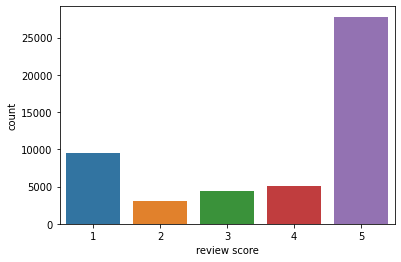

In [6]:
sns.countplot(x=df["score"])
plt.xlabel('review score');

In [7]:
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df['sentiment'] = df["score"].apply(to_sentiment)

In [8]:
df[(df.iloc[:, 10] == 2)]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sentiment
16,1feb812c-d27a-4259-8235-9d99ba839857,MaseMaju MbakeGoyang,https://play-lh.googleusercontent.com/a-/ACB-R...,Memang yang ngasih bintang 1 pada pakai jaring...,5,1,6.23.1,2023-04-12 15:27:11,"Hi Villenial.... Terima kasih atas review-nya,...",2023-04-12 15:46:40,2
32,6785bda3-5e40-44f1-9c95-27b0eb36cad5,princes marizsa,https://play-lh.googleusercontent.com/a-/ACB-R...,suka sama aplikasinya krna bsa nntn tv meski k...,5,1,6.23.1,2023-03-31 17:28:14,Hi Villenial....terimakasih atas reviewnya. Se...,2023-03-31 19:31:37,2
37,7daa7fa5-590c-4248-b1ea-7cc6d1fbfba6,farid n Ai,https://play-lh.googleusercontent.com/a-/ACB-R...,Maaf vision bukan di vision sendiri saja yg me...,5,1,6.23.1,2023-03-31 17:23:30,Hi Villenial...mohon maaf atas ketidaknyamanan...,2023-03-31 18:30:35,2
46,ef2919ed-87b4-45a7-9c96-25239cfb8359,Davin Iqbal,https://play-lh.googleusercontent.com/a/AGNmyx...,"Aplikasi nya Bagus sekali, Bisa nonton Tayanga...",4,2,6.23.1,2023-03-29 19:52:35,Mohon Maaf atas ketidaknyamanannya. Apakah bis...,2023-03-29 20:40:59,2
55,3b402b8c-ed72-4bc4-8414-3edf8f9981be,masyita salamuddin,https://play-lh.googleusercontent.com/a/AGNmyx...,Aplikasi ini tidak bagus sekarang dulu bagus n...,4,7,6.23.1,2023-02-26 18:07:33,Mohon Maaf atas ketidaknyamanannya kak Masyita...,2023-02-26 19:34:22,2
...,...,...,...,...,...,...,...,...,...,...,...
49887,c7c5d446-9072-408e-9fd7-2ded10e041fc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sip,5,0,NaN,2016-05-03 19:11:09,NaN,NaN,2
49888,54e2804f-b0ff-40df-b002-93ba06597292,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Ok,5,0,NaN,2015-11-14 00:01:24,NaN,NaN,2
49890,d09484e3-8f76-47e2-a81b-029cd8ea9cf1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Setelah sekian lama mencari app ntn film & liv...,5,1,NaN,2018-07-16 22:27:42,"Terima kasih atas review-nya, selamat menikmat...",2018-07-17 08:14:42,2
49891,0c221d28-05fc-4537-95ab-5d1ba58580ed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,NaN,5,0,NaN,2015-03-23 02:11:01,NaN,NaN,2


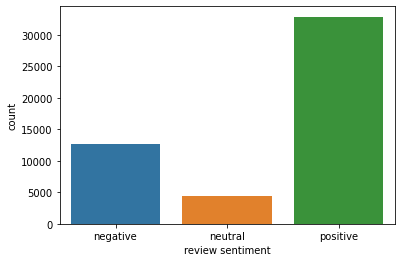

In [9]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(x = df["sentiment"])
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)

plt.xlabel('review sentiment')
plt.show()

Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

Add special tokens to separate sentences and do classification
Pass sequences of constant length (introduce padding)
Create array of 0s (pad token) and 1s (real token) called attention mask
BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.

The tokenizer will break the sentence into words and give numerical values to each word.

In [10]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [12]:
# Store length of each review 
token_lens = []

nan_rows = df[pd.isna(df["content"])]

# Drop rows with NaN values
df = df.dropna(subset=["content"])


# Iterate through the content slide
for txt in df["content"]:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

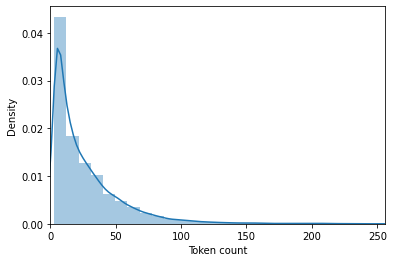

In [13]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [14]:
MAX_LEN = 160

In [15]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [16]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(39912, 11) (4989, 11) (4990, 11)


In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [18]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [31]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [33]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [36]:
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------


TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str